In [34]:
import pandas as pd
from IPython.display import display, HTML

# Cargar datos
df = pd.read_csv('../chile_weather_hourly_may_jun_2025.csv')
df = df.dropna(subset=['city', 'wind_kph'])

# Calcular promedios por ciudad
promedios = df.groupby('city')['wind_kph'].mean().reset_index()
promedios.columns = ['Ciudad', 'Velocidad Promedio del Viento (km/h)']

# Ordenar de mayor a menor
promedios = promedios.sort_values(by='Velocidad Promedio del Viento (km/h)', ascending=False)

# Mostrar como tabla HTML bonita
display(HTML(promedios.to_html(index=False, float_format="%.2f")))


Ciudad,Velocidad Promedio del Viento (km/h)
Punta Arenas,20.91
Valparaíso,12.81
Los Angeles,10.56
Puerto Natales,8.62
Puerto Montt,8.00
Antofagasta,7.60
Iquique,6.99


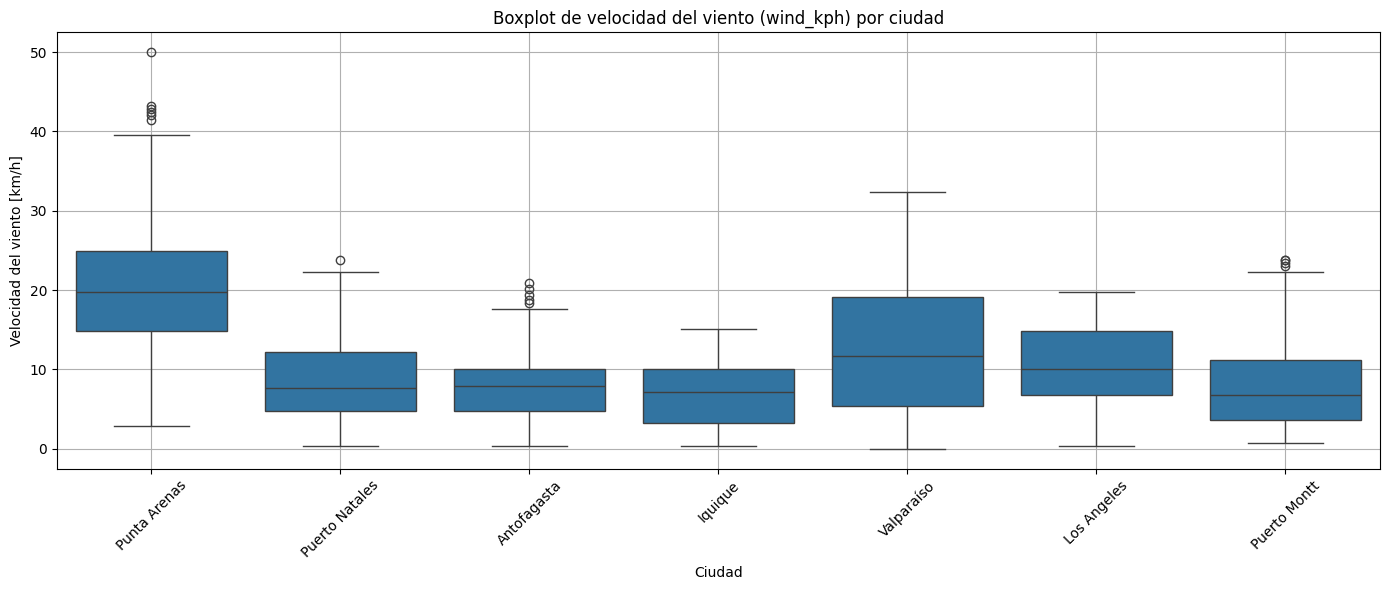

In [33]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Cargar los datos
df = pd.read_csv('../chile_weather_hourly_may_jun_2025.csv')

# Eliminar valores faltantes de las columnas que nos interesan
df = df.dropna(subset=['city', 'wind_kph'])

# Tamaño de figuras general
plt.figure(figsize=(14, 6))

# Gráfico boxplot de wind_kph por ciudad
sns.boxplot(data=df, x='city', y='wind_kph')
plt.xticks(rotation=45)
plt.title('Boxplot de velocidad del viento (wind_kph) por ciudad')
plt.ylabel('Velocidad del viento [km/h]')
plt.xlabel('Ciudad')
plt.grid(True)
plt.tight_layout()
plt.show()


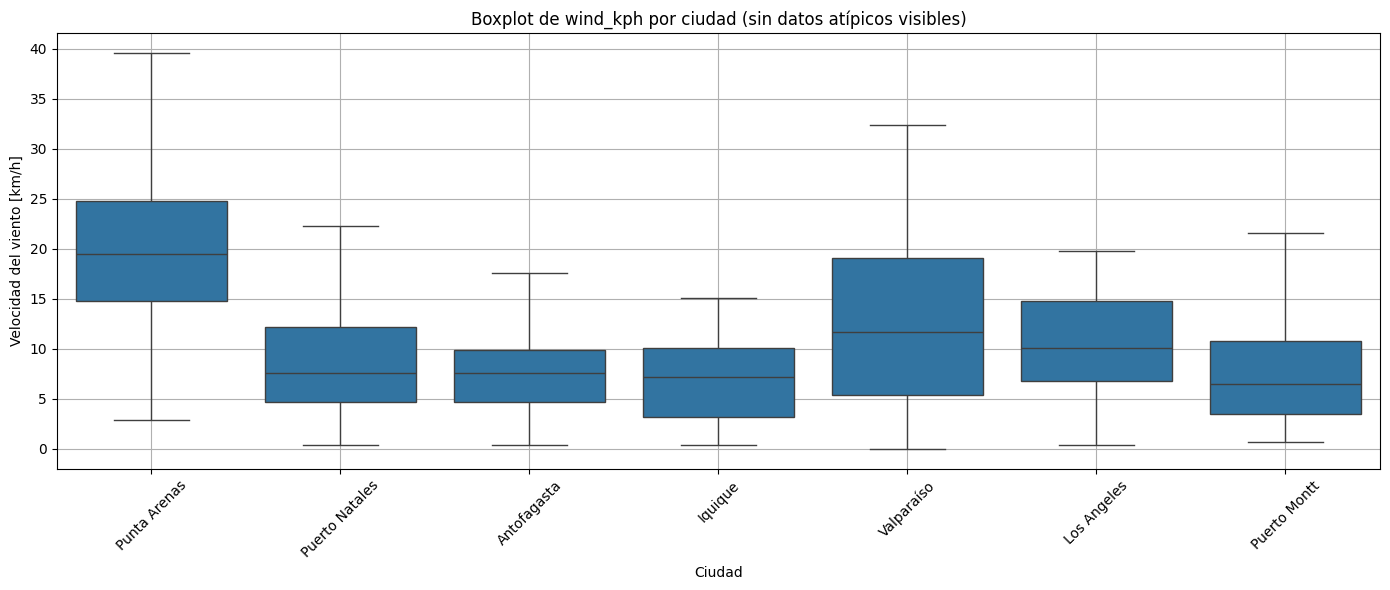

In [38]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Cargar datos
df = pd.read_csv('../chile_weather_hourly_may_jun_2025.csv')
df = df.dropna(subset=['city', 'wind_kph'])

# Eliminar outliers por ciudad usando IQR
def quitar_outliers_por_ciudad(df, columna='wind_kph'):
    df_filtrado = pd.DataFrame()
    for ciudad in df['city'].unique():
        datos = df[df['city'] == ciudad].copy()
        Q1 = datos[columna].quantile(0.25)
        Q3 = datos[columna].quantile(0.75)
        IQR = Q3 - Q1
        lim_inf = Q1 - 1.5 * IQR
        lim_sup = Q3 + 1.5 * IQR
        filtrado = datos[(datos[columna] >= lim_inf) & (datos[columna] <= lim_sup)]
        df_filtrado = pd.concat([df_filtrado, filtrado], ignore_index=True)
    return df_filtrado

# Aplicar la limpieza
df_limpio = quitar_outliers_por_ciudad(df)

# Boxplot sin puntos individuales de outliers (fliers)
plt.figure(figsize=(14, 6))
sns.boxplot(data=df_limpio, x='city', y='wind_kph', showfliers=False)  # <- esto evita que se dibujen los fliers
plt.xticks(rotation=45)
plt.title('Boxplot de wind_kph por ciudad (sin datos atípicos visibles)')
plt.ylabel('Velocidad del viento [km/h]')
plt.xlabel('Ciudad')
plt.grid(True)
plt.tight_layout()
plt.show()
# Guardar a CSV
df_limpio.to_csv('../chile_weather_filtrado.csv', index=False)

Reporte de clasificación (8 direcciones):
              precision    recall  f1-score   support

           E       0.00      0.00      0.00         7
           N       0.54      0.49      0.51        45
          NE       0.25      0.40      0.31        15
          NW       0.51      0.51      0.51        47
           S       0.51      0.58      0.54        72
          SE       0.20      0.10      0.13        10
          SW       0.57      0.57      0.57        86
           W       0.49      0.43      0.46        46

    accuracy                           0.50       328
   macro avg       0.38      0.39      0.38       328
weighted avg       0.49      0.50      0.49       328



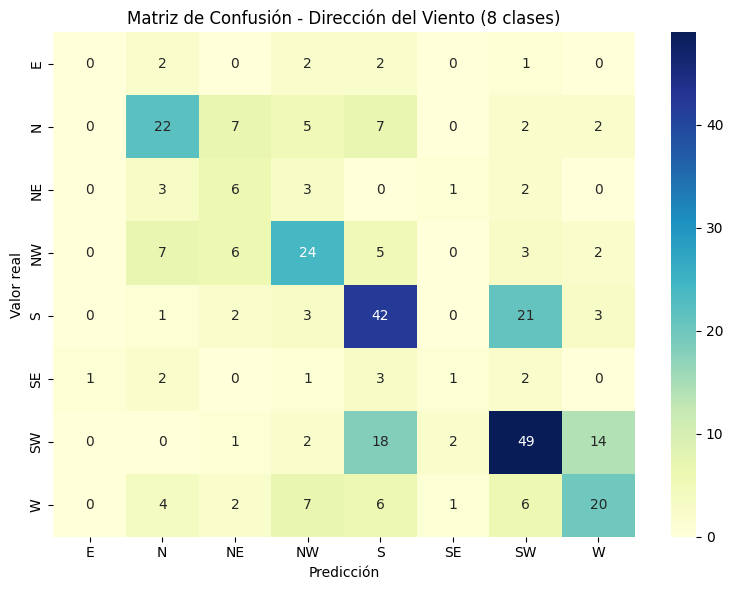

In [36]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

# 1. Cargar CSV
df = pd.read_csv("../chile_weather_filtrado.csv")

# 2. Agrupar direcciones en 8 puntos cardinales
agrupacion_8 = {
    "N": "N", "NNE": "NE", "NE": "NE", "ENE": "E",
    "E": "E", "ESE": "SE", "SE": "SE", "SSE": "S",
    "S": "S", "SSW": "SW", "SW": "SW", "WSW": "W",
    "W": "W", "WNW": "NW", "NW": "NW", "NNW": "N"
}
df['wind_dir_8'] = df['wind_dir'].map(agrupacion_8)

# 3. Seleccionar variables predictoras y objetivo
X = df[['humidity_%', 'condition_text', 'wind_kph', 'cloud_%']].copy()
y = df['wind_dir_8']

# 4. Codificar variable categórica
le_condition = LabelEncoder()
X['condition_text'] = le_condition.fit_transform(X['condition_text'])

le_dir8 = LabelEncoder()
y_encoded = le_dir8.fit_transform(y)

# 5. División en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42
)

# 6. Modelo de clasificación
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# 7. Predicción y evaluación
y_pred = model.predict(X_test)
print("Reporte de clasificación (8 direcciones):")
print(classification_report(y_test, y_pred, target_names=le_dir8.classes_))

# 8. Matriz de confusión
cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="YlGnBu",
            xticklabels=le_dir8.classes_, yticklabels=le_dir8.classes_)
plt.title("Matriz de Confusión - Dirección del Viento (8 clases)")
plt.xlabel("Predicción")
plt.ylabel("Valor real")
plt.tight_layout()
plt.show()

# 9. Guardar modelo y codificadores
with open("../modelo_direccion_8.pkl", "wb") as f:
    pickle.dump({
        "modelo": model,
        "label_encoder": le_dir8,
        "cond_encoder": le_condition
    }, f)

In [30]:
import pickle

# Cargar el modelo y los encoders
with open("../modelo_direccion_8.pkl", "rb") as f:
    data = pickle.load(f)

le_condition = data["cond_encoder"]

# Mostrar los valores conocidos (válidos) por el encoder
print("✅ Valores válidos para 'condition_text':")
for cond in le_condition.classes_:
    print("-", cond)


✅ Valores válidos para 'condition_text':
- Aguanieve moderada a intervalos en las aproximaciones
- Chubascos de nieve
- Chubascos de nieve fuertes o moderados
- Cielo cubierto
- Despejado
- Fuertes nevadas
- Ligeras lluvias
- Ligeras lluvias heladas
- Ligeras precipitaciones
- Ligeras precipitaciones de aguanieve
- Ligeras precipitaciones de nieve
- Llovizna
- Lluvia  moderada a intervalos
- Lluvia moderada
- Lluvias ligeras a intervalos
- Neblina
- Nevadas intensas
- Nevadas ligeras
- Nevadas ligeras a intervalos
- Niebla moderada
- Nieve moderada
- Nieve moderada a intervalos
- Nublado
- Parcialmente nublado
- Soleado


In [29]:
import pickle
import numpy as np

# 1. Cargar el modelo entrenado
with open("../modelo_direccion_8.pkl", "rb") as f:
    data = pickle.load(f)

modelo = data["modelo"]
le_dir8 = data["label_encoder"]
le_condition = data["cond_encoder"]

# 2. Ingresar nuevos datos manualmente (puedes cambiarlos)
nueva_muestra = {
    "humidity_%": 94,
    "condition_text": "Neblina",
    "wind_kph": 14.3,
    "cloud_%": 5
}

# 3. Validar si el valor de 'condition_text' fue visto en el entrenamiento
if nueva_muestra["condition_text"] not in le_condition.classes_:
    print(f"⚠️ El valor '{nueva_muestra['condition_text']}' no fue visto durante el entrenamiento.")
    print("Valores válidos:", list(le_condition.classes_))
else:
    # 4. Codificar 'condition_text'
    cond_encoded = le_condition.transform([nueva_muestra["condition_text"]])[0]

    # 5. Crear vector de entrada con las 4 variables
    X_new = np.array([[nueva_muestra["humidity_%"], cond_encoded, nueva_muestra["wind_kph"], nueva_muestra["cloud_%"]]])

    # 6. Predecir dirección del viento
    pred = modelo.predict(X_new)
    direccion = le_dir8.inverse_transform(pred)[0]

    print(f"🌬️ Predicción de dirección del viento: {direccion}")


🌬️ Predicción de dirección del viento: N


c:\Users\danik\OneDrive\Desktop\Minor\Proyecto\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
